## Cleaning

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import glob
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn import metrics, preprocessing
from sklearn.impute import KNNImputer
from sklearn.preprocessing import LabelEncoder

Read in player data

In [2]:
playerDf = pd.read_csv('data/CollegeBasketballPlayers2009-2021.csv', low_memory=False)

#initial dropping of inconsistant data for player data 
playerDf = playerDf.rename(columns = {'Unnamed: 64' : 'role_position'})
playerDf = playerDf.drop('Unnamed: 65', axis=1) # Has no meaning in the dataset
playerDf = playerDf.drop('ht', axis=1) # Temporarily excluding this column due to inconsistent date formats and other values
playerDf = playerDf.drop('num', axis=1) # It might denote a player's choice or position but with significant variation in meaning.
playerDf = playerDf.drop('type', axis=1) # Column has 1 unique value
playerDf= playerDf.drop('pid', axis=1) # catigorical, not needed 
playerDf= playerDf.drop('yr', axis=1) # catigorical, not needed 

playerDf.shape

(61061, 60)

Display columns with over 60% nulls and drop them

In [3]:
# Count and remove columns with over 60% nan values from players
total = len(playerDf)
for column in playerDf.columns:
    count = playerDf[column].isna().sum()
    percent= (count/ total) * 100
    if (percent>=60):
        print(f"Player  DF: Column '{column}':", f"Number of NaN: {count}", f"Percentage: {percent:.2f}%")

Player  DF: Column 'Rec Rank': Number of NaN: 42591 Percentage: 69.75%
Player  DF: Column 'pick': Number of NaN: 59626 Percentage: 97.65%


In [4]:
#Drop all the over 60% cols from the player. Dont drop pick, nan recorded as not drafted, need for predictions filling in later
playerDf = playerDf.drop('Rec Rank', axis=1) 

Findand remove redundant data 

In [5]:
player_corr_matrix = playerDf.corr()
correlation_threshold = 0.9

# Create positive correlation matrix
corr_df = playerDf.corr().abs()


# Create and apply mask
mask = np.triu(np.ones_like(corr_df, dtype=bool))
tri_df = corr_df.mask(mask)

# Find columns that meet threshold
features_to_drop = [c for c in tri_df.columns if any(tri_df[c] >= correlation_threshold)]
print(features_to_drop)

['Min_per', 'Ortg', 'eFG', 'FTM', 'twoPM', 'twoPA', 'TPM', 'rimmade', 'midmade', 'dunksmade', 'drtg', 'dporpag', 'stops', 'gbpm', 'mp', 'dreb']


In [6]:
# Remove the highly correlated features from the DataFrame
playerDf = playerDf.drop(columns=features_to_drop, axis=1)

# Display the new shape of the DataFrame
print("Shape of the DataFrame after removing highly correlated features:", playerDf.shape)

Shape of the DataFrame after removing highly correlated features: (61061, 43)


Merging each player into 1 row (save players that will be used in just the testing data) 

In [7]:
# #first seperate the players who were in the NCAA in 2021 as they will be used for traininng 
# #need to know what player to use for training
# #sperate after mergind players
# byYear= playerDf[playerDf['year'] >= 2021]
# players_and_teams_list =byYear[['player_name', 'team']].values.tolist()

In [8]:
#if drafted, change to 1 since values for drafted are 1-60 and not drafted is saved as nan
playerDf.loc[playerDf["pick"] > 0, "pick"] = 1
#not drafted was nan, replace with 0 
playerDf.loc[playerDf["pick"] != 1, "pick"] = 0

In [9]:
categorical_columns = ['player_name', 'team', 'role_position', 'conf']

# Function to calculate weighted average
def weighted_avg(group):
    categorical_data = group.iloc[-1, group.columns.isin(categorical_columns)]
    data_to_ave = group.drop(columns=categorical_columns).mean(numeric_only=True)
    
    if any(group['pick'] == 1):
        group['pick'] = 1
    return pd.concat([categorical_data, data_to_ave])

# Group by player name and team, then apply weighted average
playerDf['player_name'] = playerDf['player_name'].str.lower()
player_grouped = playerDf.groupby(['player_name', 'team'], as_index=False).apply(weighted_avg)
player_grouped.reset_index(drop=True, inplace=True)


In [10]:
playerDf=player_grouped
playerDf.head()

,player_name,team,conf,role_position,GP,usg,TS_per,ORB_per,DRB_per,AST_per,...,obpm,dbpm,ogbpm,dgbpm,oreb,treb,ast,stl,blk,pts
0,a'torey everett,Tennessee St.,OVC,Combo G,23.0,15.700000,50.080,1.600000,8.100000,14.500000,...,-4.928820,-1.477300,-5.633160,-0.881980,0.125000,0.875000,0.708300,0.083300,0.04170,2.41670
1,a'torri shine,Grambling St.,SWAC,Wing G,27.0,23.100000,49.985,4.000000,10.100000,8.200000,...,-2.114325,-4.820495,-0.919447,-4.191470,1.132150,3.831400,0.950850,0.670500,0.21585,13.02745
2,a'uston calhoun,Bowling Green,MAC,Wing F,23.5,24.850000,50.490,6.225000,12.675000,4.075000,...,-0.935753,-3.182705,7.261217,-2.661530,1.568950,4.624525,0.501925,0.400150,0.39315,11.30355
3,a.c. reid,Liberty,BSth,Combo G,29.0,17.633333,45.250,0.833333,10.666667,14.133333,...,-2.732733,-1.676557,-3.327480,-1.286542,0.126433,1.939567,1.370433,0.529367,0.10510,5.41610
4,a.c. reid,Tennessee St.,OVC,Combo G,8.0,13.900000,7.140,0.000000,6.900000,5.200000,...,-8.733310,-2.066710,-10.044700,-2.299060,0.000000,0.700000,0.400000,0.200000,0.10000,1.20000


Test grouped data

In [11]:
playerDf.loc[playerDf['player_name']=='zygis sestokas']

,player_name,team,conf,role_position,GP,usg,TS_per,ORB_per,DRB_per,AST_per,...,obpm,dbpm,ogbpm,dgbpm,oreb,treb,ast,stl,blk,pts
30195,zygis sestokas,Hofstra,CAA,NaN,23.0,11.3,59.15,2.7,6.4,6.8,...,2.4286,-0.956826,2.46174,-0.40718,0.4348,1.4348,0.5217,0.2609,0.1739,5.087


In [12]:
player_grouped['year'].tail(10)

30190    2021.0
30191    2016.5
30192    2018.5
30193    2011.0
30194    2009.5
30195    2009.0
30196    2019.0
30197    2016.5
30198    2020.0
30199    2020.5
Name: year, dtype: float64

In [13]:
playerDf.loc[playerDf['year']==2021].shape

(2528, 43)

In [14]:
player_grouped.loc[playerDf['player_name']=='pooh williams']

,player_name,team,conf,role_position,GP,usg,TS_per,ORB_per,DRB_per,AST_per,...,obpm,dbpm,ogbpm,dgbpm,oreb,treb,ast,stl,blk,pts
23634,pooh williams,Utah St.,WAC,Combo G,33.0,17.233333,53.403333,2.3,6.2,14.8,...,1.640557,-0.306989,0.531476,0.238109,0.432267,1.807133,2.033967,0.4059,0.181667,7.796367


KNN to fill in all NAN values

In [15]:
threshold = 15
missing_percentage = (playerDf.isnull().sum(axis=1) / playerDf.shape[1]) * 100
rows_to_drop = []

for index, percentage in missing_percentage.iteritems():
    if percentage > threshold:
        rows_to_drop.append(index)

playerDf = playerDf.drop(index=rows_to_drop)

In [16]:
team_label_encoder = LabelEncoder()
playerDf['team'] = team_label_encoder.fit_transform(playerDf['team'])

conf_label_encoder = LabelEncoder()
playerDf['conf'] = conf_label_encoder.fit_transform(playerDf['conf'])

role_position_label_encoder = LabelEncoder()
playerDf['role_position'] = role_position_label_encoder.fit_transform(playerDf['role_position'])

playerDf=playerDf.drop('player_name', axis=1)

In [17]:
imputer = KNNImputer(n_neighbors=10)
imputed_numeric = imputer.fit_transform(playerDf.select_dtypes(include=np.number))
dfBasketballTraining_filled = pd.DataFrame(imputed_numeric, columns=playerDf.select_dtypes(include=np.number).columns)
string_columns = playerDf.select_dtypes(include='object').columns
imputed_data = pd.concat([playerDf[string_columns], dfBasketballTraining_filled], axis=1)

In [18]:
playerDf = pd.DataFrame(imputed_data, columns=playerDf.columns)

Seperate testing and training data

In [19]:
trainDf=playerDf.loc[playerDf['year'] <2021]
testDf= playerDf.loc[playerDf['year'] >= 2021]

Feature selection 

In [20]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel

X = trainDf.drop("pick", axis=1)
y = trainDf["pick"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Fit a RandomForestClassifier
rf_classifier = RandomForestClassifier(n_estimators=100)
rf_classifier.fit(X_train, y_train)

#importance
sel = SelectFromModel(rf_classifier)
sel.fit(X_train, y_train)

# Get support and selected feature names
selected_feature_indices = sel.get_support()
selected_features = X_train.columns[selected_feature_indices]

print("Selected features:")
print(selected_features)

print("Feature importance scores:")
print(sel.estimator_.feature_importances_)


Selected features:
Index(['GP', 'FTA', 'porpag', 'adjoe', 'midmade+midmiss',
       'dunksmiss+dunksmade', 'adrtg', 'bpm', 'obpm', 'dbpm', 'ogbpm', 'dgbpm',
       'pts'],
      dtype='object')
Feature importance scores:
[0.01504113 0.0127449  0.00547024 0.05277218 0.01730781 0.01533851
 0.01557322 0.01319895 0.01475107 0.01667449 0.02736638 0.01569533
 0.01333219 0.01851112 0.0135769  0.01485451 0.01270675 0.01505277
 0.062753   0.03459112 0.01410708 0.01145076 0.0148787  0.02048307
 0.0322145  0.01528911 0.01350214 0.05552453 0.01118055 0.05506419
 0.08193069 0.02921814 0.03276128 0.04818423 0.03356593 0.01662559
 0.02383999 0.01619954 0.01600674 0.02022435 0.03043632]


## Model

In [21]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier

In [22]:
#Trying with k-fold cross validation 

In [23]:
def get_training_data(data, start, stop, end=False):
    if end==False: 
        subset = data.iloc[start:stop]
    else: #include the raminder of the samples in the last set 
        subset = data.iloc[start:]
    return subset
    

In [24]:
#get divided training data for k-crossfold validation 
#all features (no pick)
# features=['usg', 'DRB_per', 'AST_per', 'TO_per',  'twoP_per', 'blk_per', 'porpag','bpm', 'dbpm', 'ogbpm', 'dgbpm']
# features = ['GP', 'FTA', 'porpag', 'adjoe', 'adrtg', 'bpm', 'obpm', 'dbpm', 'ogbpm', 'dgbpm','blk', 'pts']
# features = ['GP', 'FTA', 'porpag', 'adjoe', 'adrtg', 'bpm', 'obpm', 'dbpm', 'blk', 'pts']
# features=['porpag','adjoe','adrtg', 'bpm', 'obpm', 'dbpm', 'ogbpm', 'dgbpm', 'pts']

      
features= selected_features

numFeatures= len(features)
rows=trainDf.shape[0]
numSets=5
perSet = int(rows/numSets)

#shuffle
trainDf = trainDf.sample(frac=1, random_state=42).reset_index(drop=True)

# 6 sets
numSets=6
perSet = int(rows/numSets)

set1=get_training_data(trainDf, 0,perSet) 
set2=get_training_data(trainDf, perSet, perSet*2) 
set3=get_training_data(trainDf, perSet*2, perSet*3) 
set4=get_training_data(trainDf, perSet*3, perSet*4) 
set5=get_training_data(trainDf, perSet*4, perSet*5) 
set6=get_training_data(trainDf, perSet*5, 0, True) #set will inclide any extera entries 

trainingSets=[set1, set2, set3, set4, set5, set6]


In [25]:
def kFoldTrain(model, sets, features, target='pick'):
    prefMetrics = {'Validation set':[],'Precision': [], 'Recall': [], 'F1 Score': []}
    sumAccuracy=0
    for j in range(len(sets)):
        valSet=sets[j]
        accuracyCount=0
        
        for i in range(len(sets)):
            #dont train validation set against validation set 
            if i!=j: 
            
                #remove target variable pick from the training and the testing data 
                trainSet=sets[i]
                trainNoTarget=trainSet[features]
                trainTarget=trainSet[target]
                valNoTarget=valSet[features]
                valTarget=valSet[target]
                
                #train 
                model.fit(trainNoTarget, trainTarget)
                
                predVals = model.predict(valNoTarget)

                prefMetrics['Validation set'].append(j+1)
                prefMetrics['Precision'].append(precision_score(valTarget, predVals))
                prefMetrics['Recall'].append(recall_score(valTarget, predVals))
                prefMetrics['F1 Score'].append(f1_score(valTarget, predVals))
            
                accuracyCount+=accuracy_score(valTarget, predVals)
                
        print("validation set ", j, "accuracy", accuracyCount/len(valSet))    
        sumAccuracy+=accuracyCount/len(valSet)
    return sumAccuracy, prefMetrics 
                

In [26]:
#citations: 
#video: https://aleksandarhaber.com/ensemble-learning-in-scikit-learn-voting-classifiers/
#Documentation: https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.VotingClassifier.html
#build model 

#the 3 models for the ensemble 
logreg = LogisticRegression(multi_class='multinomial', max_iter=2000, random_state=42)
randFor = RandomForestClassifier(n_estimators=50, random_state=15)
svm = SVC(probability=True, random_state=191) 

                                     
# voting ensemble classifier 
model = VotingClassifier(estimators=[('lr', logreg), ('rf', randFor), ('svm', svm)], voting='hard')
# model = VotingClassifier(estimators=[('kmeans', kmeans), ('rf', randFor), ('svm', svm)], voting='hard')

acc, trainMetrics=kFoldTrain(model, trainingSets, features)

validation set  0 accuracy 0.0011629904988657038
validation set  1 accuracy 0.0011591159228229375
validation set  2 accuracy 0.0011642258709373104
validation set  3 accuracy 0.0011609689809303477
validation set  4 accuracy 0.0011584982367871342
validation set  5 accuracy 0.0011633475236635781


In [27]:
print("Estimated accuracy of the model is: ", acc/len(trainingSets))

Estimated accuracy of the model is:  0.0011615245056678352


In [28]:
pd.DataFrame(trainMetrics)
#make a plot for the train metrics and also need to check the accuracy 

,Validation set,Precision,Recall,F1 Score
0,1,0.812500,0.268041,0.403101
1,1,0.920000,0.237113,0.377049
2,1,0.758621,0.226804,0.349206
3,1,0.750000,0.278351,0.406015
4,1,0.892857,0.257732,0.400000
5,2,0.695652,0.290909,0.410256
6,2,0.757576,0.227273,0.349650
7,2,0.659574,0.281818,0.394904
8,2,0.708333,0.309091,0.430380
9,2,0.805556,0.263636,0.397260


In [29]:
#test the model 
testNoPick=testDf[features]
testPick=testDf['pick']

# Predict if player was selected for the draft on the test set
predTest = model.predict(testNoPick)


Validation/testing precision, recall and fscore 

In [30]:

#preformance metrics for test set
print()
tPrecision = precision_score(testPick, predTest)
tRecall = recall_score(testPick, predTest)
tF1 = f1_score(testPick, predTest)

print('Precision on Test Set:', tPrecision)
print('Recall on Test Set:', tRecall)
print('F1-score on Test Set:', tF1)



Precision on Test Set: 0.75
Recall on Test Set: 0.15
F1-score on Test Set: 0.24999999999999997


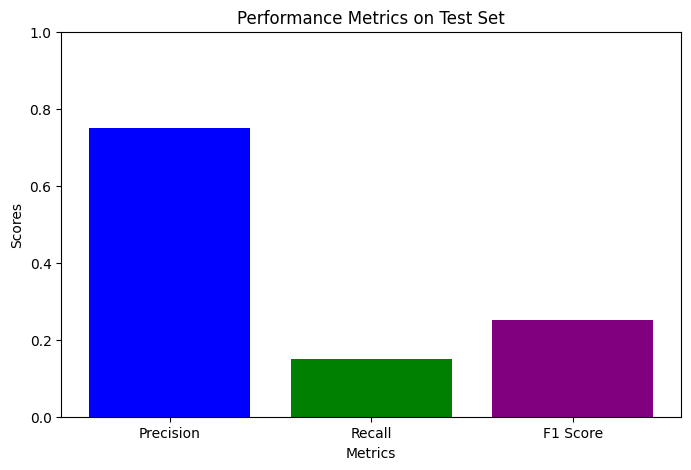

In [31]:
import matplotlib.pyplot as plt

#bar plot of the metrics
metrics = ['Precision', 'Recall', 'F1 Score']
scores = [tPrecision, tRecall , tF1]

plt.figure(figsize=(8, 5))
plt.bar(metrics, scores, color=['blue', 'green', 'purple'])
plt.xlabel('Metrics')
plt.ylabel('Scores')
plt.title('Performance Metrics on Test Set')
plt.ylim(0, 1)  # Set y-axis limit to better visualize scores between 0 and 1
plt.show()

## Test run pref values for cross fold and various features selected:

1) 5 training sets, features = ['GP', 'FTA', 'porpag', 'adjoe', 'adrtg', 'bpm', 'obpm', 'dbpm', 'blk', 'pts']

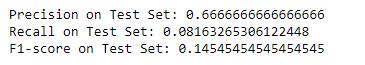

2) 5 training sets, features=['usg', 'DRB_per', 'AST_per', 'TO_per',  'twoP_per', 'blk_per', 'porpag','bpm', 'dbpm', 'ogbpm', 'dgbpm']

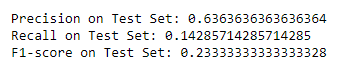

3) 5 training sets, features=['porpag', 'adjoe','adrtg', 'bpm', 'obpm', 'dbpm', 'ogbpm', 'dgbpm', 'pts']

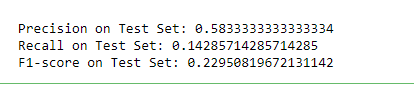

4) 6 training sets, features=['porpag','adjoe','adrtg', 'bpm', 'obpm', 'dbpm', 'ogbpm', 'dgbpm', 'pts']
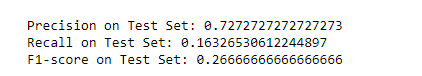

5) 7 training sets give the same metrics as 6


# Testing by training on balanced data

In [53]:
def get_training_data(dataframe, replacement, features = 13, multiplicity = 10):
    trainingCount = int(features*multiplicity/2)
    not_drafted = dataframe[dataframe['pick'] == 0].sample(n=trainingCount, replace=replacement)
    drafted = dataframe[dataframe['pick'] == 1].sample(n=trainingCount, replace=replacement)
    return pd.concat([not_drafted, drafted], ignore_index=True)

In [54]:
def trainRandSets(model, features, sets, target='pick'): 
    prefMetrics = {'Precision': [], 'Recall': [], 'F1 Score': []}

    for data in sets:
        y = data[target]
        X = data.drop(target, axis=1) 
        
        trainTarget, valTarget, trainNoTarget, valNoTarget = train_test_split(X, y, test_size=0.2, random_state=42)

        # Train
        model.fit(trainNoTarget, trainTarget)  

        predVals = model.predict(valNoTarget)

        prefMetrics['Precision'].append(precision_score(valTarget, predVals))
        prefMetrics['Recall'].append(recall_score(valTarget, predVals))
        prefMetrics['F1 Score'].append(f1_score(valTarget, predVals))

    return prefMetrics

In [55]:
def shuffle(): 
    return trainDf.sample(frac=1, random_state=42).reset_index(drop=True)

set1=get_training_data(trainDf, False, len(features))
shuffle()
set2=get_training_data(trainDf, False, len(features))
shuffle()
set3=get_training_data(trainDf, False, len(features))
shuffle()
set4=get_training_data(trainDf, False, len(features))
shuffle()
set5=get_training_data(trainDf, False, len(features))

trainingSets=[set1, set2, set3, set4, set5]

In [56]:
logreg = LogisticRegression(multi_class='multinomial', max_iter=2000, random_state=42)
randFor = RandomForestClassifier(n_estimators=50, random_state=15)
svm = SVC(probability=True, random_state=1) 

# voting ensemble classifier 
model2 = VotingClassifier(estimators=[('lr', logreg), ('rf', randFor), ('svm', svm)], voting='hard')

#recycle the kfold train method since it's still just testing all the data 
trainMetrics=trainRandSets(model2,features, trainingSets)


ValueError: Unknown label type: 'continuous-multioutput'